# Test PMFG


In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from time import time
import timeit

from PMFG import PMFG
#%matplotlib inline
import matplotlib.pyplot as plt

## Importing data

More rows than columns; not good. Collecting a more tick data of the same stocks is trivial, but for now we'll work with this dataset.

In [2]:
raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')
log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
# drop first row of raw prices so it has the same dimensions as the log-returns DF
raw_asset_prices_df = raw_asset_prices_df.iloc[1:]
stock_names = log_returns_df.columns

df_shape = (raw_asset_prices_df.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")

log_returns_df.head()

There are 251 rows and 504 columns in the dataset.
Data timeperiod covers: 2020/6/22 to 2021/6/18


,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
Date,,,,,,,,,,,,,,,,,,,,,
2020/6/22,0.025827,0.027395,0.014404,0.001799,0.018099,0.013969,-0.010896,-0.006596,-0.003064,0.004898,...,-0.004257,0.005945,0.005634,0.026948,-0.007939,-0.014094,-0.015945,0.000000,-0.002328,0.009217
2020/6/23,0.021120,0.006659,0.018470,0.012545,0.009140,0.008607,0.012123,0.007475,-0.003703,0.016705,...,0.000609,0.026735,-0.001995,0.001635,0.007580,0.014546,-0.007910,0.036142,0.039983,0.006650
2020/6/24,-0.017810,-0.020363,-0.010915,-0.034522,-0.021598,-0.022401,-0.033961,-0.041715,-0.021509,-0.028701,...,-0.057015,-0.080661,-0.020547,-0.039003,-0.029188,-0.020055,-0.062254,-0.040357,-0.039983,-0.031989
2020/6/25,0.013188,0.012557,0.007353,0.007068,0.005846,0.006515,0.034268,0.025818,-0.001073,0.024053,...,0.052743,0.093765,0.014354,-0.004682,-0.009673,-0.021406,0.002026,0.013634,0.010435,0.006820
2020/6/26,-0.031208,-0.020219,-0.022657,-0.086826,-0.056056,-0.058155,-0.056378,-0.026974,-0.013407,-0.032038,...,-0.052098,-0.008170,-0.014540,-0.037970,-0.038100,-0.048179,-0.049448,-0.052390,-0.048444,-0.019735


## Construct correlation matrix
Simple rolling window corr with shrinkage.

In [3]:
raw_corr = log_returns_df.corr()

shr_coef = 1e-4
#shr_target=np.ones((df_shape[1], df_shape[1]))
shr_target=np.eye(df_shape[1])

correlation_matrix = raw_corr*(1-shr_coef) + shr_target*shr_coef
print('Condition number of sample correlation matrix: %.2e' %np.linalg.cond(raw_corr))
print('Condition number of shrunk correlation matrix: %.2e' %np.linalg.cond(correlation_matrix))
correlation_matrix.head()

Condition number of sample correlation matrix: 1.13e+19
Condition number of shrunk correlation matrix: 1.49e+06


,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
AAPL,1.000000,0.694200,0.691205,0.634493,0.522702,0.512583,0.029423,0.492938,0.220624,0.205805,...,0.025386,-0.016511,0.115755,-0.015630,0.113051,0.024639,0.014589,-0.048178,-0.046476,0.174052
MSFT,0.694200,1.000000,0.741015,0.608564,0.717165,0.705709,0.040791,0.500559,0.284647,0.324833,...,-0.011969,-0.025407,0.099012,-0.058433,0.072387,-0.047254,-0.014123,-0.063651,-0.067568,0.198791
AMZN,0.691205,0.741015,1.000000,0.688021,0.622603,0.626005,-0.070769,0.478916,0.109943,0.217174,...,-0.123943,-0.089610,-0.038883,-0.092398,0.002334,-0.070554,-0.108014,-0.055348,-0.060529,0.113214
FB,0.634493,0.608564,0.688021,1.000000,0.658567,0.657867,0.020714,0.349706,0.187031,0.319269,...,-0.031311,-0.046235,0.007846,-0.037580,0.074092,0.007478,-0.002316,0.010992,0.011035,0.176672
GOOGL,0.522702,0.717165,0.622603,0.658567,1.000000,0.993162,0.189587,0.377768,0.281600,0.377338,...,0.127267,0.168430,0.140180,0.083248,0.154922,0.043158,0.147497,0.181127,0.186247,0.266149


## Casting correlation values into edge weights

In [5]:
# edges are weighted
Gt1 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
#print(nx.info(Gt1))
print('\nSanity check: edge weights are non-binary...')
nx.adjacency_matrix(Gt1)[0,1]


Sanity check: edge weights are non-binary...


0.694200351385983

## Graph Filtering

In [6]:
timestamp = time()
# G0_filtered = nx.minimum_spanning_tree(Gt1)
G0_filtered = PMFG(G0_filtered).compute()

In [ ]:
print('Time taken to construct the filtered graph: %.2f s' %(time()-timestamp))
print(nx.info(G0_filtered))

In [7]:
# check that the filtered graph is weighted:
#G0_filtered.edges('AAPL')
print('\nSanity check: edge weights are non-binary...')
G0_filtered.adj['AAPL']

Time taken to construct the filtered graph: 0.45 s
Name: 
Type: Graph
Number of nodes: 504
Number of edges: 503
Average degree:   1.9960


AtlasView({'PBCT': {'weight': -0.07949460871863029}})

## Centrality measures
Centrality/peripherality measures: 
* degree 
* betweenness-centrality
* eccentricity
* closeness
* eigenvector-centrality

In [8]:
print('Testing runtime for graph operations:')

print('\nDegree')
%timeit nx.degree(G0_filtered)
print('\nBetweenness Centrality')
%timeit nx.betweenness_centrality(G0_filtered)
print('\nEccentricity')
%timeit nx.eccentricity(G0_filtered)
print('\nCloseness')
%timeit nx.closeness_centrality(G0_filtered)
print('\nEigenvector Centrality')
%timeit nx.eigenvector_centrality(G0_filtered)
print('\nPlanarity (of original/dense graph)')
%timeit nx.check_planarity(G0_filtered)

Testing runtime for graph operations:


Degree
1.4 µs ± 209 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

Betweenness Centrality
821 ms ± 94.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Eccentricity
267 ms ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Closeness
288 ms ± 47.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Eigenvector Centrality
77.1 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Planarity (of original/dense graph)
26.4 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# unweighted degree
#deg= pd.DataFrame.from_dict(dict(G0_filtered.degree), orient='index', columns = ['D'])
# weighted degree, a.k.a. strength
deg= pd.DataFrame.from_dict(dict(G0_filtered.degree(weight='weight')), orient='index', columns = ['D'])
BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G0_filtered), orient='index', columns = ['BC'])
ecc= pd.DataFrame.from_dict(nx.eccentricity(G0_filtered), orient='index', columns = ['E'])
clo= pd.DataFrame.from_dict(nx.closeness_centrality(G0_filtered), orient='index', columns = ['C'])
EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G0_filtered), orient='index', columns = ['EC'])

In [10]:
#centralities_names = ['BC', 'C', 'D', 'E', 'EC']
centralities_names = ['D', 'BC', 'E', 'C', 'EC']

centralities = deg
centralities['BC'] = BC
centralities['E']  = ecc
centralities['C']  = clo
centralities['EC'] = EC
print(centralities.head())

              D   BC   E         C            EC
AAPL  -0.079495  0.0  11  0.192868  2.913558e-05
MSFT  -0.130235  0.0  11  0.192868  2.913558e-05
AMZN  -0.238419  0.0  11  0.192868  2.913558e-05
FB    -0.111662  0.0   9  0.221977  4.355697e-03
GOOGL -0.024764  0.0  14  0.111530  1.602348e-07


In [11]:
centralities.corr()

,D,BC,E,C,EC
D,1.000000,-0.767071,0.104942,-0.177163,-0.752468
BC,-0.767071,1.000000,-0.099506,0.194557,0.485889
E,0.104942,-0.099506,1.000000,-0.950289,-0.530921
C,-0.177163,0.194557,-0.950289,1.000000,0.642150
EC,-0.752468,0.485889,-0.530921,0.642150,1.000000


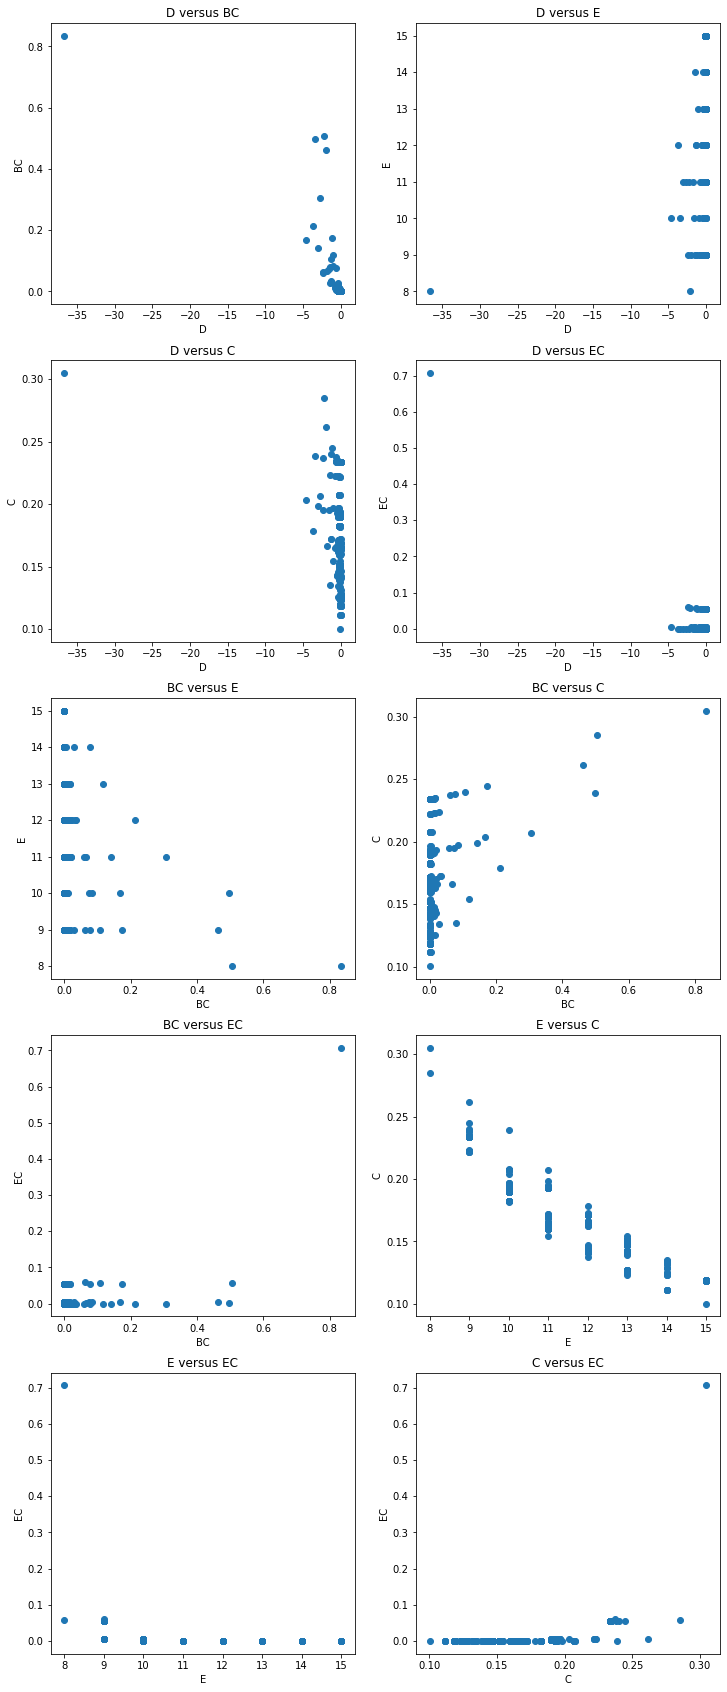

In [12]:
from itertools import combinations

plot_len = 6
plt.figure(figsize=(plot_len*2, plot_len*5))

i=1
for x,y in combinations(centralities_names, 2):
    plt.subplot(5, 2, i)      #5C2 = 10
    plt.scatter(centralities[x], centralities[y])
    plt.title(x+' versus '+y)
    plt.xlabel(x)
    plt.ylabel(y)
    i+=1

In [13]:
print('argmax node for each feature: ')
for cen_measure in centralities_names:
    print(cen_measure + ': ' + centralities[cen_measure].idxmax())

argmax node for each feature: 
D: EXC
BC: CLX
E: CSCO
C: CLX
EC: CLX


## Use D/BC/E/C/EC as features for embedding

Explained variance by first two PCs:
[0.58348603 0.31505639]
First two PCs:
['D', 'BC', 'E', 'C', 'EC']
[[-0.42546521  0.37458201 -0.42101579  0.46486407  0.53414864]
 [-0.50872095  0.49043431  0.52677048 -0.46685523  0.07236184]]
D : -0.425 | -0.509
BC : 0.375 | 0.490
E : -0.421 | 0.527
C : 0.465 | -0.467
EC : 0.534 | 0.072


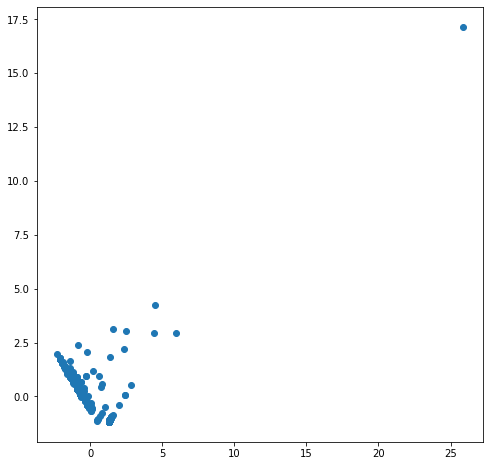

In [15]:
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

# preprocess the data to have zero mean and unit var.
# (or do i have to normalize by L2/L1?)
cen = scale(centralities)
pca = PCA(n_components=2)
pca.fit(cen)

print('Explained variance by first two PCs:')
print(pca.explained_variance_ratio_)
print('First two PCs:')
print(centralities_names)
print(pca.components_)

for cname, pc1, pc2 in zip(centralities_names, pca.components_[0],  pca.components_[1]):
    print(cname, ': %.3f | %.3f' %(pc1, pc2))
    
DR = pca.transform(cen)
plt.figure(figsize=(8,8))
plt.scatter(DR[:,0], DR[:,1]);